<a href="https://colab.research.google.com/github/HoseinNekouei/RNN-Exercise/blob/main/Amazon_sentiment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import Model, layers
import matplotlib.pyplot as plt

In [4]:
MAX_TOKEN =  10000
MAX_LEN = 512
EPOCHS = 10
BATCH_SIZE = 64

In [5]:
# Read cvs file in memory
data = pd.read_csv('/content/drive/MyDrive/dataset/amazon_baby.csv',
                   usecols=[1,2],nrows=10000)

# drop null reviews
empty_idxs = data[data['review'].isnull()].index
data.drop(empty_idxs, inplace=True)

features = data['review'].astype(str)
labels = data['rating'].apply(lambda x: 0 if x > 0 and x <=2 else 1)

# Split dataset into training and testing dataset
x_train, x_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    random_state= 42,
                                                    shuffle=True)
print(x_train.shape)

(7983,)


In [6]:
# Create a TextVectorization layer
vectorizer = layers.TextVectorization(max_tokens= MAX_TOKEN,
                                                output_mode= 'int',
                                                output_sequence_length= MAX_LEN)

# Adapt the TextVectorization layer to text data
vectorizer.adapt(x_train)

print(vectorizer.get_vocabulary()[:10])

['', '[UNK]', 'the', 'and', 'i', 'to', 'it', 'a', 'is', 'this']


In [7]:
# Define input layer
inputs = keras.Input(shape = (1,), dtype = tf.string)

# vectorize input
vectorize = vectorizer(inputs)

# Embedding layer
embeded= layers.Embedding(input_dim= MAX_TOKEN, output_dim= 256)(vectorize)

x = layers.LSTM(units= 128, recurrent_dropout=0.5, return_sequences=True)(embeded)
x = layers.LSTM(units= 64, recurrent_dropout=0.5, return_sequences=True)(x)
x = layers.LSTM(units= 32, recurrent_dropout=0.5, return_sequences=True)(x)
x = layers.LSTM(units= 32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)

# Output layer
outputs = layers.Dense(1, activation='sigmoid')(x)

# Create Model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer= 'adam',
              loss = 'binary_crossentropy',
              metrics= 'accuracy')

model.summary()

history = model.fit(x_train , y_train, validation_data= (x_test, y_test),
                    epochs = EPOCHS, batch_size= BATCH_SIZE)

loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test loss: {loss :.2f}, Test accuracy: {accuracy :.2f}')

# save model
model.save("amazon_model", save_format='tf')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 512)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 512, 256)          2560000   
                                                                 
 lstm (LSTM)                 (None, 512, 128)          197120    
                                                                 
 lstm_1 (LSTM)               (None, 512, 64)           49408     
                                                                 
 lstm_2 (LSTM)               (None, 512, 32)           12416     
                                                             

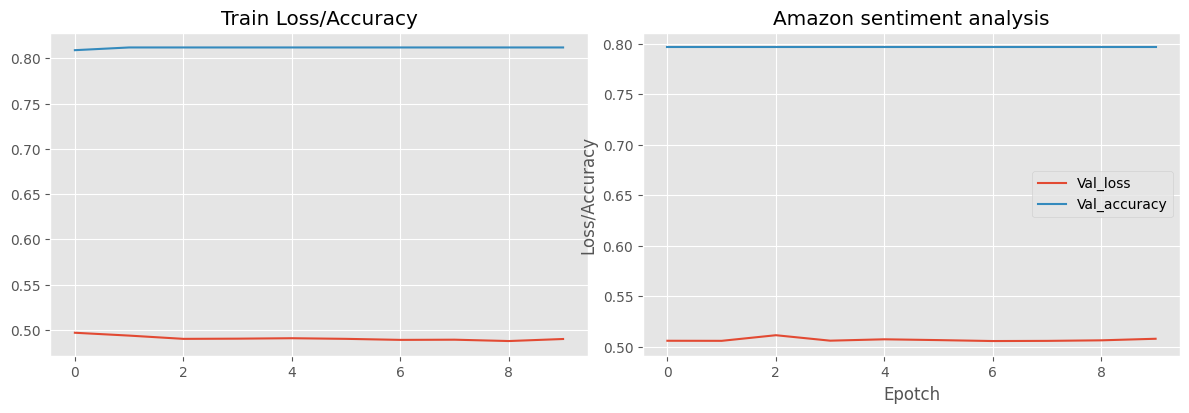

In [8]:
plt.style.use('ggplot')

# Get the loss and accuracy values from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize =(12,4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(EPOCHS), loss, label='Loss')
plt.plot(np.arange(EPOCHS), accuracy, label='accuracy')
plt.title('Train Loss/Accuracy')

plt.subplot(1, 2, 2)
plt.plot(np.arange(EPOCHS), val_loss, label= 'Val_loss')
plt.plot(np.arange(EPOCHS), val_accuracy, label= 'Val_accuracy')
plt.title('Test Loss/Accuracy')

plt.tight_layout()
plt.legend()

plt.xlabel('Epotch')
plt.ylabel('Loss/Accuracy')
plt.title('Amazon sentiment analysis')

plt.show()